In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
# move into project directory
repo_name = "Image-Colorization"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/Image-Colorization
common	     datautils	  Index.ipynb  output			 README.md
config.yaml  experiments  index.py     preprocess_imagenette.py  requirements.txt
data	     Index_bc.py  models       project-structure.md	 run.yaml


In [ ]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

In [ ]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
#!tar -xvzf data/imagenette2-320.tgz
#!unzip -qq data/imagenette2-320-processed.zip -d data/


In [3]:
# setup some imports
#custom imports
from common.transforms import ToTensor
from datautils.datareader import DataReader
from datautils.datareader import ImagenetteReader
from datautils.dataset import CustomDataset
from datautils.dataset import CustomImagenetDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_saved_model, get_modelinfo, get_model_data
from models.unet import UNet
from models.conv_net import ConvNet
from models.custom_models import get_model

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from experiments.experiments import Experiment
from common.visualization import Visualization
from experiments.test_model import ModelTester

In [ ]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'L', 'data_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization', 'use_gpu': True, 'y_key': 'AB'}


In [ ]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 256, 'crop_dim': 224}, 'train': {'shuffle_data': True, 'batch_size': 32, 'val_split_method': 'fixed-split', 'k': 3, 'val_percentage': 20, 'loss': 'l1', 'epoch_interval': 2, 'num_epochs': 10}, 'model': {'name': 'conv_net', 'optimizer': 'Adam', 'lr': 0.0001, 'weight_decay': 1e-07, 'amsgrad': True, 'momentum': 0.9}, 'dataset': {'name': 'imagenette', 'size': 'subset'}}


In [ ]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
# read and load custom data

#save X_key and y_key
save2config('X_key', 'L')
save2config('y_key', 'AB')

if exp_params['dataset']['name'] == 'custom':
    #preprocess data or load preprocessed data (custom)
    dr = DataReader()
    ds = dr.get_split_data()
    Ltr, ABtr, ftr_len = ds['Ltr'], ds['ABtr'], ds['ftr_len']
    Lte, ABte, te_len = ds['Lte'], ds['ABte'], ds['te_len']
    print('Shape of X and y:', ds['Ltr'].shape, ds['ABtr'].shape)

    #transform data
    composed_transforms =  transforms.Compose([
        ToTensor()
    ])
    #convert to dataset
    ftr_dataset = CustomDataset(Ltr, ABtr, ftr_len)
    te_dataset = CustomDataset(Lte, ABte, te_len)
    smlen = int(0.01 * len(ftr_dataset))
    smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
    smftrte_dataset = torch.utils.data.Subset(ftr_dataset, list(range(10)))
    smtelen = int(0.1 * len(te_dataset))
    smfte_dataset = torch.utils.data.Subset(te_dataset, list(range(smtelen)))
    print('Full train dataset length:', len(ftr_dataset))
    print('Test dataset length:', len(te_dataset))
    print('Subset train dataset length:', smlen)
    print('Subset test dataset length:', smtelen, '\n')
elif exp_params['dataset']['name'] == 'imagenette':
    dr = ImagenetteReader()
    train_paths, test_paths = dr.get_data_filepaths()
    ftr_dataset = CustomImagenetDataset(train_paths)
    te_dataset = CustomImagenetDataset(test_paths)
    smlen = int(0.01 * len(ftr_dataset))
    smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
    smtelen = int(0.01 * len(te_dataset))
    smfte_dataset = torch.utils.data.Subset(te_dataset, list(range(smtelen)))
    smftrte_dataset = torch.utils.data.Subset(smftr_dataset, list(range(10)))
    print('Full train dataset length:', len(ftr_dataset))
    print('Test dataset length:', len(te_dataset))
    print('Subset train dataset length:', smlen)
    print('Subset test dataset length:', smtelen, '\n')
else:
    raise SystemError('Invalid dataset name passed!')



Full train dataset length: 9469
Test dataset length: 3925
Subset train dataset length: 94
Subset test dataset length: 39 



In [ ]:
# model training

if exp_params['dataset']['name'] == 'custom':
    if exp_params['dataset']['size'] == 'subset':
        #model training with small dataset (custom)
        exp = Experiment(exp_params["model"]["name"], smftr_dataset)
        model_history = exp.train()
    else:
        #model training with full dataset (custom)
        exp = Experiment(exp_params["model"]["name"], ftr_dataset)
        model_history = exp.train()
elif exp_params['dataset']['name'] == 'imagenette':
    if exp_params['dataset']['size'] == 'subset':
        #model training with small dataset (imagenette)
        composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])
        exp = Experiment(exp_params["model"]["name"], smftr_dataset, composed_transforms, 'imagenette')
        model_history = exp.train()
    else:
        #model training with full dataset (imagenette)
        composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])
        exp = Experiment(exp_params["model"]["name"], ftr_dataset, composed_transforms, 'imagenette')
        model_history = exp.train()
else:
    raise SystemError('Invalid dataset name passed!')

Running straight split
	Running Epoch 1


		Running through validation set: 100%|██████████| 1/1 [00:06<00:00,  6.85s/it]


	Epoch 1 Training Loss: 6.583384639338443
	Epoch 1 Validation Loss: 6.622189998626709
	Running Epoch 2


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


	Epoch 2 Training Loss: 6.571521708839818
	Epoch 2 Validation Loss: 6.621548175811768
	Running Epoch 4


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


	Epoch 4 Training Loss: 6.562079228852925
	Epoch 4 Validation Loss: 6.620617389678955
	Running Epoch 6


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


	Epoch 6 Training Loss: 6.548861026763916
	Epoch 6 Validation Loss: 6.619950294494629
	Running Epoch 8


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


	Epoch 8 Training Loss: 6.5352081374118205
	Epoch 8 Validation Loss: 6.619437217712402
	Running Epoch 10


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


	Epoch 10 Training Loss: 6.527099609375
	Epoch 10 Validation Loss: 6.6189470291137695



Model validation results

Model results




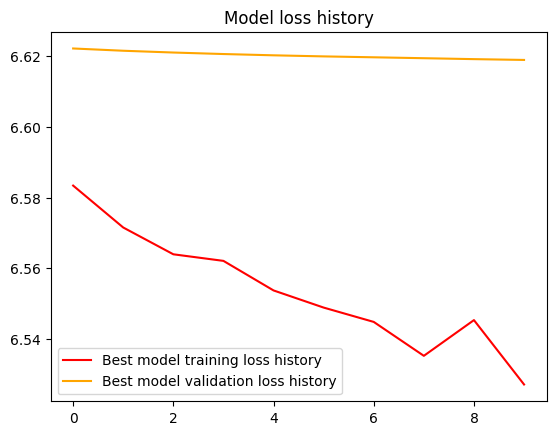


Model Training Loss: 6.527099609375
Model Validation Loss: 6.6189470291137695


In [ ]:
# test model on validation set

if exp_params['dataset']['name'] == 'custom' or exp_params['dataset']['name'] == 'imagenette':
    # get best model with custom dataset
    model, model_history, _ = get_model_data(exp_params["model"]["name"])
    #model = get_saved_model(model, '')
    model_info = get_modelinfo('')
    print("\nModel validation results")
    #visualization results
    vis = Visualization(model_info, model_history)
    vis.get_results()
else:
    raise SystemError('Invalid dataset name passed!')

In [ ]:
#script for testing the model

from common.utils import get_exp_params, get_accuracy, get_config, get_model_filename
from torch.utils.data import DataLoader
import torch
from matplotlib import pyplot as plt
from common import colorspaces
from common.colorspaces import rgb_to_lab
from torchvision import transforms


class ModelTester:

    def __init__(self, model, te_dataset, data_transform = None, result_sample_len = 10):
        cfg = get_config()
        self.te_dataset = te_dataset
        self.model = model.cpu()
        self.model.eval()
        self.exp_params = get_exp_params()
        self.te_loader = DataLoader(self.te_dataset,
            batch_size = self.exp_params['train']['batch_size'],
            shuffle = False
        )
        self.output_dir = cfg['output_dir']
        self.X_key = cfg['X_key']
        self.y_key = cfg['y_key']
        self.data_transform = data_transform
        self.result_sample_len = result_sample_len

    def __loss_fn(self, loss_name = 'cross-entropy'):
        if loss_name == 'cross-entropy':
            return torch.nn.CrossEntropyLoss()
        elif loss_name == 'mse':
            return torch.nn.MSELoss()
        elif loss_name == 'l1':
            return torch.nn.L1Loss()
        else:
            raise SystemExit("Error: no valid loss function name passed! Check run.yaml")

    def __plot_predicted_images(self, L, AB_pred, RGB, AB):
        L = L.transpose(1, 3).transpose(1, 2)
        if not(torch.is_tensor(AB)):
            AB = torch.from_numpy(AB)
        AB = AB.transpose(1, 3).transpose(1, 2)
        AB_pred = AB_pred.transpose(1, 3).transpose(1, 2)
        pred_LAB = torch.concat((L, AB_pred.detach()), dim = 3)
        n = self.result_sample_len
        plt.clf()
        plt.figure(figsize=(n,7))
        #print(RGB.size(), L.size(), AB_pred.size(), pred_LAB.size())
        #print(AB_pred.min(), AB_pred.max(), AB.min(), AB.max())
        for i in range(self.result_sample_len):
            pos = i + 1
            #Plot true image
            plt.subplot(7,n,pos)
            plt.imshow(RGB[i,:,:,:])
            plt.axis(False)

            pos = i + n + 1
            #Plot L channel
            plt.subplot(7,n,pos)
            plt.imshow(L[i,:,:],cmap="gray")
            plt.axis(False)

            pos = i + (2 * n) + 1
            #Plot true A channel
            plt.subplot(7, n, pos)
            plt.imshow(AB[i,:,:, 0])
            plt.axis(False)

            pos = i + (3 * n) + 1
            #Plot predicted A channel
            plt.subplot(7,n,pos)
            plt.imshow(AB_pred[i,:,:,0].detach())
            plt.axis(False)

            pos = i + (4 * n) + 1
            #Plot true B channel
            plt.subplot(7, n, pos)
            plt.imshow(AB[i,:,:,1])
            plt.axis(False)

            pos = i + (5 * n) + 1
            #Plot predicted B channel
            plt.subplot(7,n,pos)
            plt.imshow(AB_pred[i,:,:,1].detach())
            plt.axis(False)

            pos = i + (6 * n) + 1
            #Convert LAB prediction to RGB and plot
            pred_RGB = colorspaces.lab_to_rgb(pred_LAB[i,:,:,:])
            #print(pred_RGB.min(), pred_RGB.max(), RGB[i].min(), RGB[i].max())
            #pred_RGB = 255.0 * pred_RGB
            #pred_RGB = pred_RGB.type(torch.LongTensor)
            plt.subplot(7,n,pos)
            plt.imshow(pred_RGB[0,:,:,:])
            plt.axis(False)

        plt.savefig(f'{self.output_dir}/test_results.png')
        plt.show()

    def __get_lab_images(self, batch_rgb):
        L = torch.empty((1, 1, self.exp_params['transform']['crop_dim'], self.exp_params['transform']['crop_dim'])) #np.empty((1, 224, 224))
        AB = torch.empty((1, 2, self.exp_params['transform']['crop_dim'], self.exp_params['transform']['crop_dim'])) #np.empty((1, 224, 224, 2))
        inv_transform = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
        for i in range(batch_rgb.shape[0]):
            #rgb_img = batch_rgb[i].transpose(0, 2).transpose(0, 1).float()
            rgb_img = batch_rgb[i].float()
            if self.data_transform:
                rgb_img = self.data_transform(rgb_img)
            rgb_img = inv_transform(rgb_img)
            rgb_img = rgb_img.transpose(0, 2).transpose(0, 1)
            lab_img = rgb_to_lab(rgb_img)
            lab_img = lab_img.transpose(3, 1).transpose(3, 2)
            l = lab_img[:, 0, :, :]
            ab = lab_img[:, 1:, :, :]
            L = torch.cat((L, l[:, None, :, :]), axis=0) #np.append(L, l, axis=0)
            AB = torch.cat((AB, ab), axis=0)  #np.append(AB, ab, axis=0)
        L = L[1:]
        AB = AB[1:]
        return L, AB

    def test_and_plot(self, RGB, ABtrue, model_type = 'best_model', save_model_temporarily = False):
        loss_fn = self.__loss_fn(self.exp_params["train"]["loss"])
        running_loss = 0.0
        acc = 0
        for _, batch in enumerate(self.te_loader):
            op = self.model(batch[self.X_key])
            loss = loss_fn(op, batch[self.y_key])
            running_loss += loss.item()
            acc = get_accuracy(op, batch[self.y_key])
            self.__plot_predicted_images(batch[self.X_key], op, RGB, ABtrue)
        print("\nTest Loss:", running_loss/len(self.te_loader))
        print("Test Accuracy:", acc/len(self.te_loader), "\n")

    def test_imagenette_and_plot(self, model_type = 'best_model'):
        loss_fn = self.__loss_fn(self.exp_params["train"]["loss"])
        running_loss = 0.0
        acc = 0

        for batch_idx, batch in enumerate(self.te_loader):
            batch[self.X_key], batch[self.y_key] = self.__get_lab_images(batch['RGB'])
            #batch[self.X_key] = batch[self.X_key].float()
            #batch[self.y_key] = batch[self.y_key].float()
            op = self.model(batch[self.X_key])
            loss = loss_fn(op, batch[self.y_key])
            running_loss += loss.item()
            acc = get_accuracy(op, batch[self.y_key])
            RGB = batch['RGB'].transpose(1, 3).transpose(1, 2)
            if batch_idx == 0:
                self.__plot_predicted_images(batch[self.X_key], op, RGB, batch[self.y_key])
        print("\nTest Loss:", running_loss/len(self.te_loader))
        print("Test Accuracy:", acc/len(self.te_loader), "\n")





Testing Saved Model on subset of training set


<Figure size 640x480 with 0 Axes>

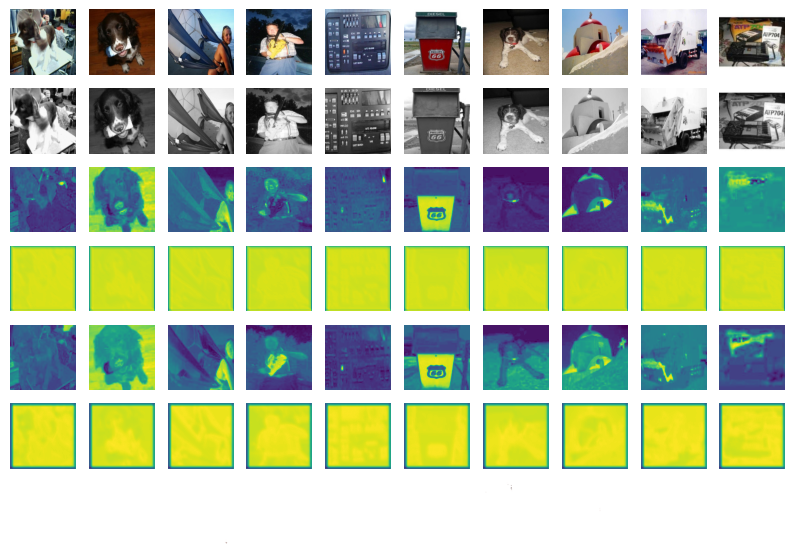


Test Loss: 7.382551193237305
Test Accuracy: tensor(0.) 



Testing Saved Model on subset of test set


<Figure size 640x480 with 0 Axes>

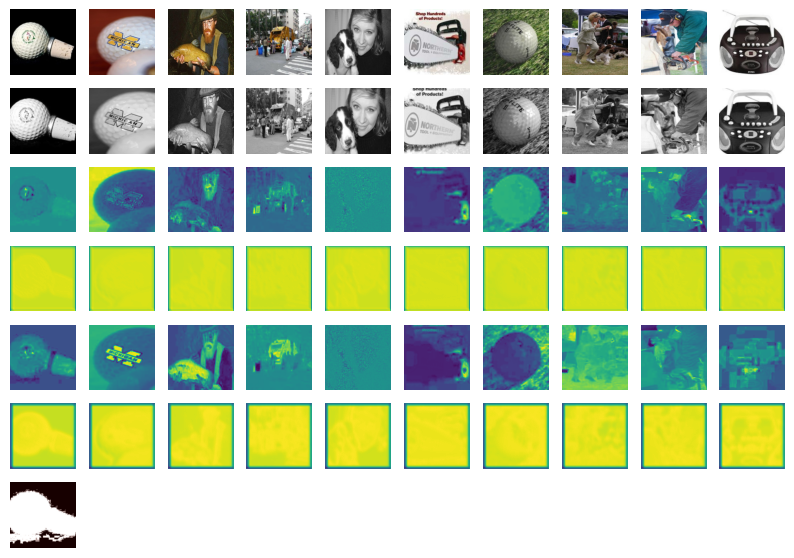

In [ ]:
# test fine-tuned model

if exp_params['dataset']['name'] == 'custom':
    #model testing with small subset of training dataset
    model = get_model(exp_params["model"]["name"])
    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
    print("\n\nTesting Saved Model on Training set subset")
    mt = ModelTester(model, smftrte_dataset)
    mt.test_and_plot(ds["RGBtr"], ABtr, "best_model", True)
    if exp_params['dataset']['size'] == 'subset':
        print("\n\nTesting Saved Model subset of test set")
        mt = ModelTester(model, smfte_dataset)
        mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)
    else:
        print("\n\nTesting Saved Model on full test set")
        mt = ModelTester(model, te_dataset)
        mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)
elif exp_params['dataset']['name'] == 'imagenette':
    #model testing with small subset of training dataset (imagenette)
    model = get_model(exp_params["model"]["name"])
    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
    print("\n\nTesting Saved Model on subset of training set")
    mt = ModelTester(model, smftrte_dataset, composed_transforms)
    mt.test_imagenette_and_plot(True)
    if exp_params['dataset']['size'] == 'subset':
        print("\n\nTesting Saved Model on subset of test set")
        mt = ModelTester(model, smfte_dataset, composed_transforms)
        mt.test_imagenette_and_plot(True)
    else:
        print("\n\nTesting Saved Model on full test set")
        mt = ModelTester(model, te_dataset, composed_transforms)
        mt.test_imagenette_and_plot(True)
else:
    raise SystemError('Invalid dataset name passed!')
